# Training a Resnet in Pytorch

Deepam Minda  
2024-08-10

# Introduction

In my last post [Intro to CNNs](./00_cnn_basics.ipynb), we discussed the
basics of CNNs and how to train a simple CNN from scratch. In this post,
we will train a ResNet in Pytorch.

Resnets came around right after VGGs, where the author explored the idea
of training very deep networks for better performance, since deeper
models could in thoery learn more complex features. But after a certain
point, more depth didnt help with wither validation accuracy nor
training performance. This was confusing, since we would assume a larger
model can atleast replicate the performance of a smaller network and
then some!

Mathematically, if we have a shallower network $H(x)$ that performs
well, a deeper network $F(x)$ should be able to learn an identity
mapping in its additional layers, effectively becoming:

$F(x) = H(x) + (F(x) - H(x))$

where $(F(x) - H(x))$ is the residual mapping. Instead of hoping that
$F(x)$ will learn the entire desired mapping, we can explicitly let it
learn the residual mapping $(F(x) - H(x))$. This is the key idea behind
ResNets: learning residual functions with reference to the layer inputs,
rather than learning unreferenced functions.

This approach allows for the creation of very deep networks without the
problem of vanishing gradients, as the gradient can flow directly
through the skip connections (also known as shortcut connections) during
backpropagation. We can imagine this as a graident highway that goes
right through the network and then comes back to the input.

<figure>
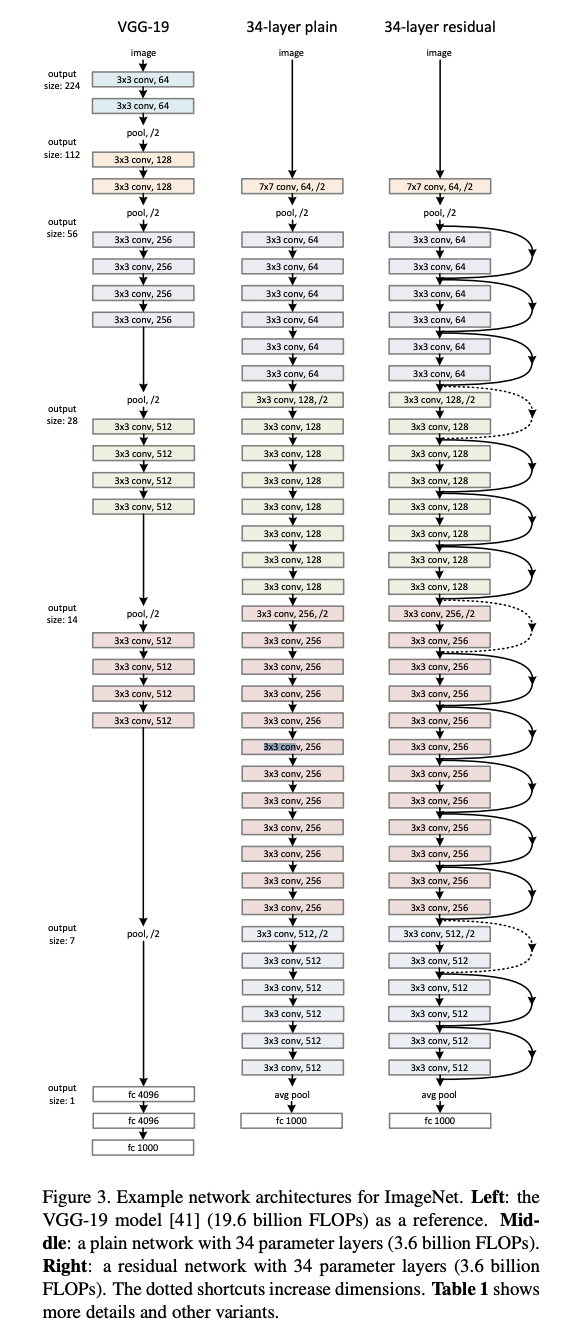
<figcaption aria-hidden="true">This is a
resnet-architecture</figcaption>
</figure>

# VGGs

Since so much of the comparison is done with VGGs it is important to
understand them too. Ignoring batch dimension for now, passing through
CNNs can be visualized as volumes of data moving through through the
network, volume being $(H, W, C)$ where $H, W$ are the height and width
of the image and $C$ is the number of channels.

<figure id="fig-vgg">
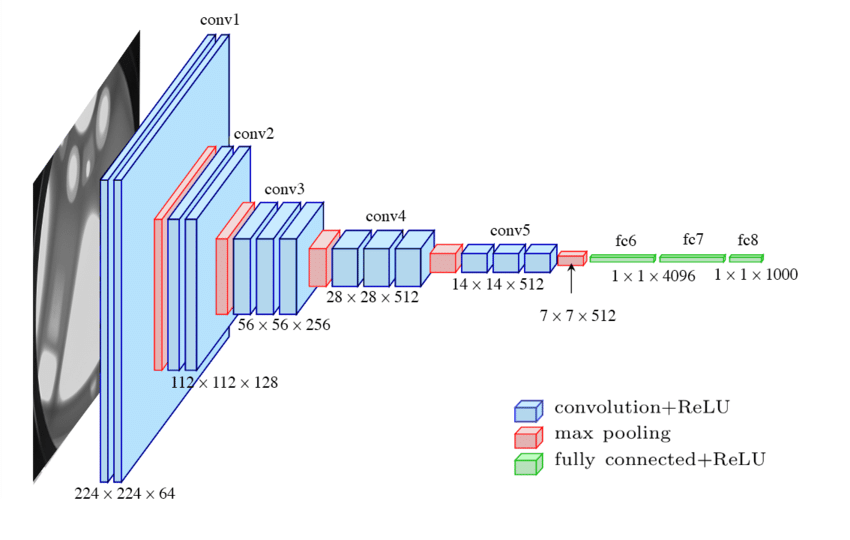
<figcaption>Figure 1: vgg-19-architecture</figcaption>
</figure>

In VGGs

-   there are 5 Conv blocks followed by some FC layers for
    classification. The Conv blocks can be thought of as a feature
    extractor.
-   each Conv block is a sequence of come `CONV->RELU` layers followed
    by a max_pool layer.
-   each conv layer has a kernel size of 3x3, stride=1 and padding=1.
-   The output of the last conv block is flattened and passed to the FC
    layers.
-   the FC layers have fixed sizes = \[4096, 4096, 1000\] with ReLU and
    Dropout after each layer.
-   Output is a 1000 sized vector., which represents Imagenet classes.

## ConvReLU Layer

Each block contains some conv_layers followed by a max_pool layer. If
the input to a block is $(H, W, C)$, the output of the block is
$(H/2, W/2, C*2)$. All in all each block still preserves the total
volume.

Let us look inside a conv block, for eg the conv2 block in
<a href="#fig-vgg" class="quarto-xref">Figure 1</a>. We can see that the
particular block has a max_pool (red) layer and 2 single-conv
layers(blue). Each single-conv layer within that block is a:

`conv_layer = [CNN->ReLU]`

In torch,

In [ ]:
import torch 
from torch import nn

class ConvReLU(nn.Module):
    """
    A single conv layer followed by batchnorm and activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size, activation=nn.ReLU(), stride=1, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.activation = activation
        
    def forward(self, x):
        if self.activation is not None:
            x = self.activation(self.conv(x))
        else:
            x = self.conv(x)

        return x


Lets create the conv1 layer and visualize the input and output volumes.
The input is a rgb image of size `224x224x3`

In [ ]:
input_img = torch.rand(224, 224, 3)   
 
# input images must have shape (C,H,W) this is usually managed by torch's to_tensor transform
input_img = torch.permute(input_img, (2, 0, 1))      

# conv layer params -> C_in=3, C_out=64, K=3, S=1, P=1
conv_layer_1 = ConvReLU(3, 64, kernel_size=3, stride=1, padding=1) 
conv_layer_2 = ConvReLU(64, 64, kernel_size=3, stride=1, padding=1)

# max pool layer params -> K=2, S=2
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

print("input volume = {}\n".format(input_img.shape))
print("output volume after conv_layer_1 = {}".format(conv_layer_1(input_img).shape))
print("output volume after conv_layer_2 = {}".format(conv_layer_2(conv_layer_1(input_img)).shape))
# print("output volume after max_pool = {}".format(max_pool(conv_layer_2(conv_layer_1(input_img))).shape))

## Block of ConvReLU layers

Now to make a block of VGG, we combine multiple such layers together. If
you see the <a href="#fig-vgg" class="quarto-xref">Figure 1</a>, each
block’s has a red layer in the beginning. The red layer is a max_pool
layer with stride=2 and kernel_size=2. This results in the $H,W$ being
halved. Then the subsequent conv_layers preserve the $H,W$ and double
the channels. Lets look at a block below:

`Block = [conv_layer_1->[conv_layer_i]*(n-1)]`.

The feature extractor will look like this:

\[`block_1 -> Max_pool -> block_2 -> Max_pool -> block_3 -> ...`\]

Lets create a block class:

In [ ]:
class Block(nn.Module):

    def __init__(self, input_channels, num_layers, out_channels, activation=nn.ReLU()):
        super().__init__()
        
        self.out_channels = input_channels*2 if out_channels is None else out_channels
        
        # first layer must half the H_in,W_in and double the C_in with S=2, P=1
        conv_1 = ConvReLU(input_channels, self.out_channels, kernel_size=3, stride=1, padding=1)
        layers = [conv_1]
        
        # rest of the layers preserve the H_in, W_in and C_in with S=1 and P=1
        for _ in range(num_layers-1):
            conv_ = ConvReLU(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1)
            layers.append(conv_)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

conv1_block = Block(input_channels=3, num_layers=2, out_channels=64)

x = conv1_block(input_img)

print("output volume after conv1_block = {}".format(x.shape))

# conv_block_2 has half the h,w (due to max pool right before it) and double the input channels. 
conv2_block = Block(input_channels=64, num_layers=2, out_channels=128)
x = conv2_block(max_pool(x))

print("output volume after conv2_block = {}".format(x.shape))


## VGG model

We can go on this way for the rest of the blocks, but lets bring it
together in a VGG class itself.

Lets write down the vgg configuration as a list of items. The model can
be imagined as a feature extractor with a classifier head on top.

The classifier part has fixed configuration, but the feature extractor
can be configured by passing a list of numbers and strings to the
constructor. Each item is either a number or a string and represents a
conv layer or a max_pool layer. The number is the number of conv layers
in the block, and the string is ‘M’ which indicates a max pool layer.

The classifier part consists of 2 hidden-FC layers (4096 neurons each)
with activations and dropout regularization added. The final layer is
the classifier head with 1000 outputs. (Imagenet dataset has 1k classes)

Lastly, to enable the model to initialize with variable input sizes, we
have used a dynamic input size of the 1st FC layer., and a dynamic
hidden_fc_size for the last FC layer. This will allow us to experiment
with smaller datasets locally

In [ ]:
_vgg_config = {
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}
import logging 
logging.basicConfig(level=logging.DEBUG)

class VGG(nn.Module):
    def __init__(self, config, input_shape=(224,224,3), dropout=0.5, num_classes=1000, hidden_fc_size=4096):
        super().__init__()

        self.input_shape = input_shape
        self.output_shape = self.input_shape
        self.hidden_fc_size = hidden_fc_size
        prev_channels = self.input_shape[2]
        
        self.blocks = []
        for i in config:
            if i == 'M':
                self.blocks.append(nn.MaxPool2d(kernel_size=2, stride=2)) 
                self.output_shape = (self.output_shape[0]//2, self.output_shape[1]//2, self.output_shape[2])
            else:
                self.blocks.append(ConvReLU(prev_channels, i, kernel_size=3, stride=1, padding=1))
                self.output_shape = (self.output_shape[0], self.output_shape[1], i)
                prev_channels = i

        self.feature_extractor = nn.Sequential(*self.blocks)
        
        self.ConvMLP = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.output_shape[0]*self.output_shape[1]*self.output_shape[2], self.hidden_fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden_fc_size, self.hidden_fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Linear(self.hidden_fc_size, num_classes)

    def forward(self, x):
        # if a single item turn into a batch
        if x.ndim == 3:
            x = x.unsqueeze(0)

        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # this flattens the tensor to (batch_size, -1)
        x = self.ConvMLP(x)
        x = self.head(x)
        return x

Now lets visualize the model, output shapes of various layers and its
size, etc using torchinfo.summary(). To install the package run
`pip install torchinfo` on your terminal.

In [ ]:
from torchinfo import summary

vgg19 = VGG(_vgg_config['vgg19'])
summary(vgg19, input_size=(3,224,224))

A pretty huge model (140million parameters) isn’t it?! The original
model was trained on the entire Imagenet dataset (150gb). But we’ll use
the TinyImagenet dataset(\<1gb) for this example. So we’ll use a much
smaller model.

In [ ]:

NUM_CLASSES=200 # Tiny ImageNet has 200 classes
IMG_SIZE = 64
device = "mps" if torch.backends.mps.is_available() else "cpu"

model = VGG(
    _vgg_config['vgg11'], 
    input_shape=(IMG_SIZE, IMG_SIZE, 3), 
    num_classes=NUM_CLASSES,
    hidden_fc_size=1026
).to(device)
        
summary(model, input_size=(3,IMG_SIZE,IMG_SIZE))

This brings our model size down to a much more manageble 12million
parameters from the original ~140 million parameters.

For training we’ll use the Adam optimizer and learing rate of 0.001.
We’ll also use the CrossEntropyLoss as the loss function as this is a
classification task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm import tqdm
import urllib.request
import zipfile
from PIL import Image

if not os.path.exists("data/"):
    os.mkdir("data/")

# Hyperparameters
BATCH_SIZE = 4
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
DATASET_PATH = "./data/tiny-imagenet-200"

# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    filename = "tiny-imagenet-200.zip"
    extract_path = DATASET_PATH
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, filename)
        
        print("Extracting Tiny ImageNet...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(".")
        
        os.remove(filename)
        print("Tiny ImageNet downloaded and extracted.")
    else:
        print("Tiny ImageNet already exists.")
    os.system("mv tiny-imagenet-200 data/tiny-imagenet-200")
    return extract_path

# Custom Dataset for Tiny ImageNet
class TinyImageNetDataset(Dataset):
    def __init__(self, root, split='train', transform=None, labels=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        

        if split == 'train':
            for class_dir in os.listdir(os.path.join(root, 'train')):
                class_path = os.path.join(root, 'train', class_dir, 'images')
                for img_name in os.listdir(class_path):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(int(class_dir[1:]))
        elif split == 'val':
            val_annotations = os.path.join(root, 'val', 'val_annotations.txt')
            with open(val_annotations, 'r') as f:
                for line in f:
                    img_name, class_id, _, _, _, _ = line.strip().split('\t')
                    print()
                    self.images.append(os.path.join(root, 'val', 'images', img_name))
                    self.labels.append(int(class_id[1:]))
        self.labelset = list(set(self.labels)) if labels is None else labels
        self.labels_to_class = {label:idx for idx,label in enumerate(self.labelset)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels_to_class[self.labels[idx]]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Download and extract the dataset
if os.path.exists("./data/tiny-imagenet-200"):
    dataset_path = DATASET_PATH
else:
    dataset_path = download_and_extract_tiny_imagenet()

# Data transforms
train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    # transforms.Resize(64),
    # transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = TinyImageNetDataset(dataset_path, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(dataset_path, split='val', transform=val_transform, labels=train_dataset.labelset)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

# Initialize model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TensorBoard writer
writer = SummaryWriter('runs/vgg_tiny_imagenet')

def train_and_validate(epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    val_loss = 0
    val_correct = 0

    # Training
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training")):
        print(batch_idx)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        print(f"train loss {torch.mean(train_loss)}")
        writer.add_scalar('Loss/train_step', loss.item())
        # writer.add_scalar('Loss/val', val_loss, epoch)
    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            writer.add_scalar('Loss/val_step', loss.item())
            val_correct += pred.eq(target.view_as(pred)).sum().item()
            print(f"val loss {torch.mean(val_loss)}")
    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / len(val_loader.dataset)

    # Log to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Training loop
for epoch in range(NUM_EPOCHS):
    train_and_validate(epoch)

writer.close()
print("Training completed!")

-   Running vgg11 on colab gives us a score of ~28% accuracy on the
    validation set in 20 epochs, while training loss and val loss both
    were kind of still decreasing.

In [ ]:
import matplotlib.pyplot as plt

def plot_params_and_grads(model, n=3):
    grad_values = [(name, param.grad.abs().cpu().detach().numpy())
                   for name, param in model.named_parameters()
                   if param.grad is not None]
    
    def plot_grads(grad_values, title_prefix):
        num_plots = min(n, len(grad_values))
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
        if num_plots == 1:
            axes = [axes]  # Ensure axes is iterable if only one plot

        for idx in range(num_plots):
            name, grad = grad_values[idx]
            axes[idx].hist(grad.flatten(), bins=50)
            axes[idx].set_title(f'{title_prefix} Layer {name}')
            axes[idx].set_xlabel('Gradient Magnitude')
            axes[idx].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

    # Plot first n parameters
    plot_grads(grad_values[:n], title_prefix='First')

    # Plot last n parameters
    plot_grads(grad_values[-n:], title_prefix='Last')


plot_params_and_grads(model, n=3)

-   Scaling to vgg_16:

          suprisingly model isnt learning at all. loss not going down. upon inspection of gradients we find that while training vgg_199 there are practically no gradients.

          Also note that grads start even when loss isnt decreasing at the first few steps.

    Look at the the below figures:

    \### VGG-11 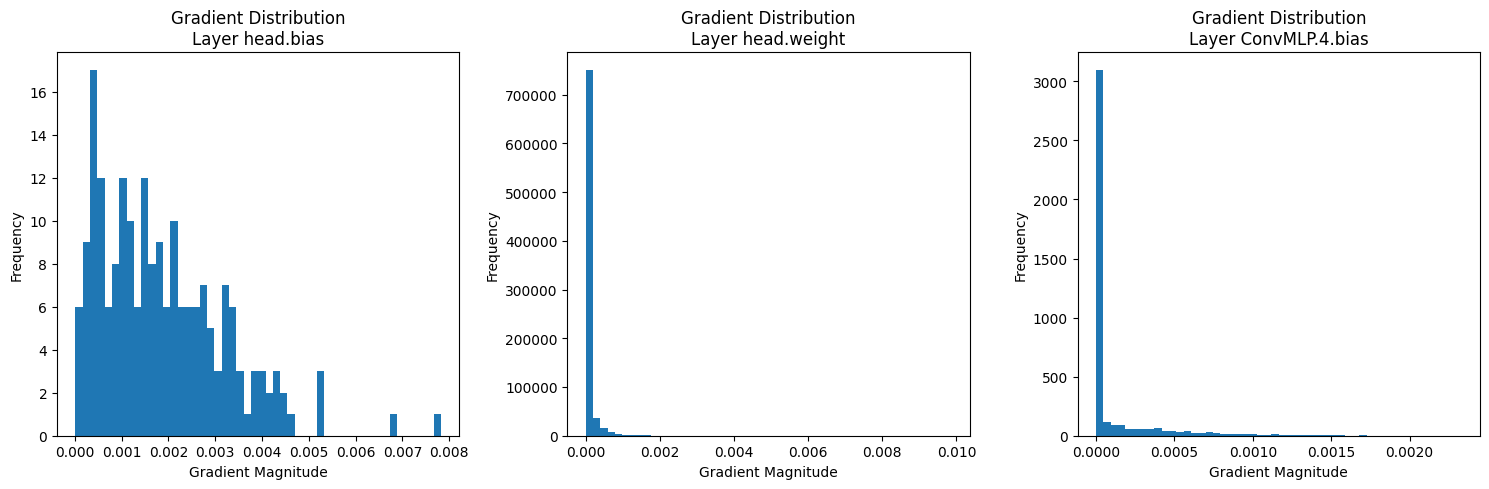

    <figure id="fig-vgg_11_first_layers_grad_plot">
    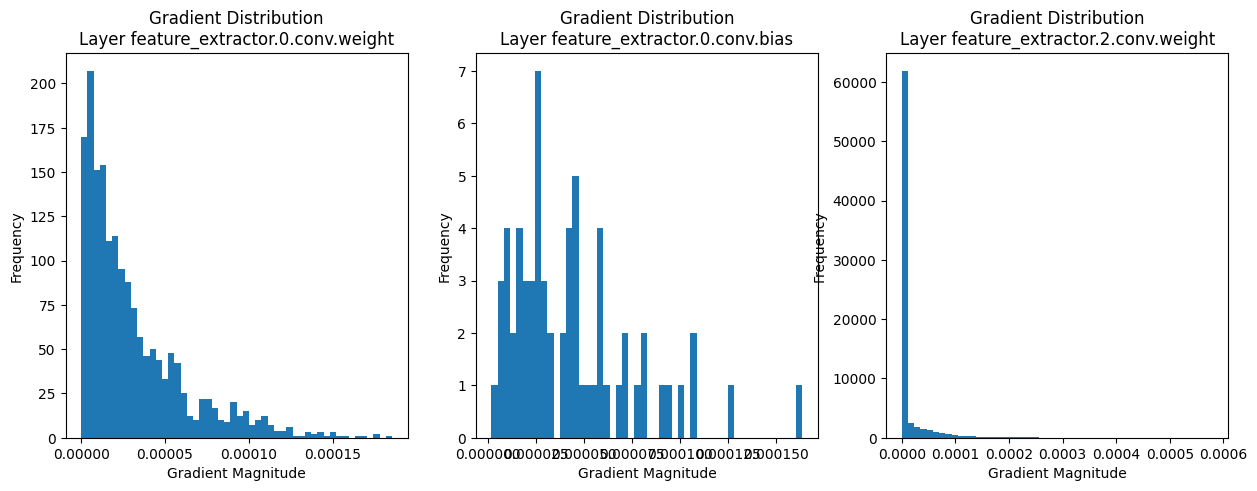
    <figcaption>Figure 2: “VGG-11 First Layers Gradient Plot”</figcaption>
    </figure>

    \### VGG-16 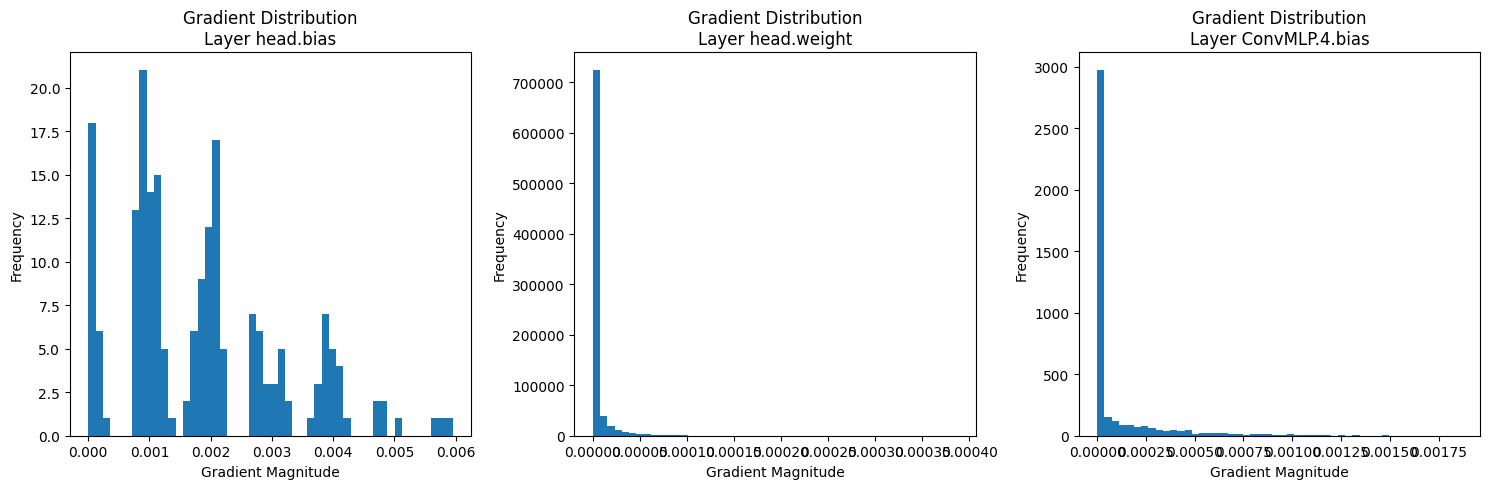

    <figure id="fig-vgg_16_first_layers_grad_plot_vanishing-grads">
    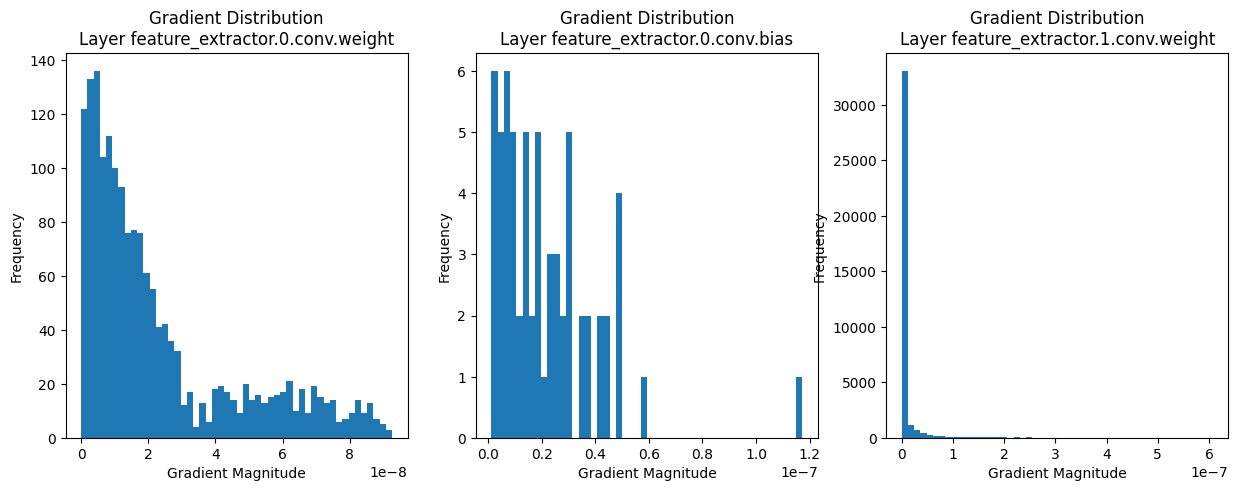
    <figcaption>Figure 3: “VGG-16 First Layers Gradient Plot”(Vanishing
    Gradients)</figcaption>
    </figure>

-   Does removing bottlenecked maxpool before fc layers help?: No, it
    doesnt. :(

-   what about vgg13? being clser to the 11 variant this doesnt
    experience vanishing gradients.

This is esssentialy the central limitations that still remain after
going very deep. Depth is not enough, we need better ways to allow
gradients to be propagated through these deep networks.

### computational considerations

A usual Conv2d layer has a computation complexity of
$O(H_{in}*W_{in}*k^2*C_{in}*C_{out})$. Derivation:

-   number of output cells = $H_{out}*W_{out}*C_{out}$
-   computation required to compute each output cell = $k^2*C_{in}$
-   number of ops  
    -\> number of output cells \* computation required to compute each
    output cell  
    -\> $H_{out}*W_{out}*k^2*C_{in}*C_{out}$

# Inception

VGGs large networks deal with issues of overfitting and increased
computation. After it focus shifted to making the networks more compute
efficient. Aiming to solve these issues by introducing extra sparsity in
the network, the Inception model was proposed.

In [136]:
class NaiveInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NaiveInceptionBlock, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv5x5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2) # padding to make sure h,w remains same
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        out1 = self.conv1x1(x)
        out2 = self.conv3x3(x)
        out3 = self.conv5x5(x)
        # out4 = self.maxpool(x)
        return torch.cat([out1, out2, out3], dim=1)
        # return [out1, out2, out3, out4]


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_1, out_channels_3, out_channels_5, out_channels_dim_red_3, out_channels_dim_red_5, pool_proj_dim):
        super(InceptionBlock, self).__init__()
        self.conv1x1 = ConvReLU(in_channels, out_channels_1, kernel_size=1, stride=1, padding=0)
        
        self.dim_reduction_3x3 = ConvReLU(in_channels, out_channels_dim_red_3, kernel_size=1, stride=1, padding=0)
        self.conv3x3 = ConvReLU(out_channels_dim_red_3, out_channels_3, kernel_size=3, stride=1, padding=1)
        
        self.dim_reduction_5x5 = ConvReLU(in_channels, out_channels_dim_red_5, kernel_size=1, stride=1, padding=0)
        self.conv5x5 = ConvReLU(out_channels_dim_red_5, out_channels_5, kernel_size=5, stride=1, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvReLU(in_channels, pool_proj_dim, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        out1 = self.conv1x1(x)
        
        out2 = self.dim_reduction_3x3(x)
        out2 = self.conv3x3(out2)
        
        out3 = self.dim_reduction_5x5(x)
        out3 = self.conv5x5(out3)
        
        out4 = self.maxpool(x)
        out4 = self.pool_proj(out4)
        # return [out1, out2, out3, out4]
        return torch.cat([out1, out2, out3, out4], dim=1)

In [140]:
inp = torch.rand(1, 256, 64, 64) # some intermediate layer output

block = NaiveInceptionBlock(256, 64)
out = block(inp)
print(out.shape)
print(summary(NaiveInceptionBlock(256, 64), input_size=(256, 64, 64)))


torch.Size([1, 192, 64, 64])
Layer (type:depth-idx)                   Output Shape              Param #
NaiveInceptionBlock                      [64, 192, 64]             --
├─Conv2d: 1-1                            [64, 64, 64]              16,448
├─Conv2d: 1-2                            [64, 64, 64]              147,520
├─Conv2d: 1-3                            [64, 64, 64]              409,664
Total params: 573,632
Trainable params: 573,632
Non-trainable params: 0
Total mult-adds (G): 2.35
Input size (MB): 4.19
Forward/backward pass size (MB): 6.29
Params size (MB): 2.29
Estimated Total Size (MB): 12.78

In [129]:
conv_block = ConvReLU(256, 192, 3)
out = conv_block(inp)
print(out.shape)
print(summary(conv_block, input_size=(256, 64, 64)))

torch.Size([1, 192, 64, 64])
Layer (type:depth-idx)                   Output Shape              Param #
ConvReLU                                 [192, 64, 64]             --
├─Conv2d: 1-1                            [192, 64, 64]             442,560
├─ReLU: 1-2                              [192, 64, 64]             --
Total params: 442,560
Trainable params: 442,560
Non-trainable params: 0
Total mult-adds (G): 5.44
Input size (MB): 4.19
Forward/backward pass size (MB): 6.29
Params size (MB): 1.77
Estimated Total Size (MB): 12.26

In [147]:
out_channels = 192//4
block = InceptionBlock(256, out_channels, out_channels, out_channels, 64, 32, out_channels)
out = block(inp)
print(out.shape)
print(summary(block, input_size=(256, 224, 224)))

torch.Size([1, 192, 64, 64])
Layer (type:depth-idx)                   Output Shape              Param #
InceptionBlock                           [48, 896, 224]            --
├─ConvReLU: 1-1                          [48, 224, 224]            --
│    └─Conv2d: 2-1                       [48, 224, 224]            12,336
├─ConvReLU: 1-10                         --                        (recursive)
│    └─ReLU: 2-2                         [48, 224, 224]            --
├─ConvReLU: 1-3                          [64, 224, 224]            --
│    └─Conv2d: 2-3                       [64, 224, 224]            16,448
├─ConvReLU: 1-10                         --                        (recursive)
│    └─ReLU: 2-4                         [64, 224, 224]            --
├─ConvReLU: 1-5                          [48, 224, 224]            --
│    └─Conv2d: 2-5                       [48, 224, 224]            27,696
├─ConvReLU: 1-10                         --                        (recursive)
│    └─ReLU: 2-6 